In [1]:
import os
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle

import tensorflow as tf
import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from textwrap import wrap

In [2]:
image_path = 'flickr30k/Images'
caption_path = 'flickr30k/captions.txt'

data = pd.read_csv(caption_path)
data.head()

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


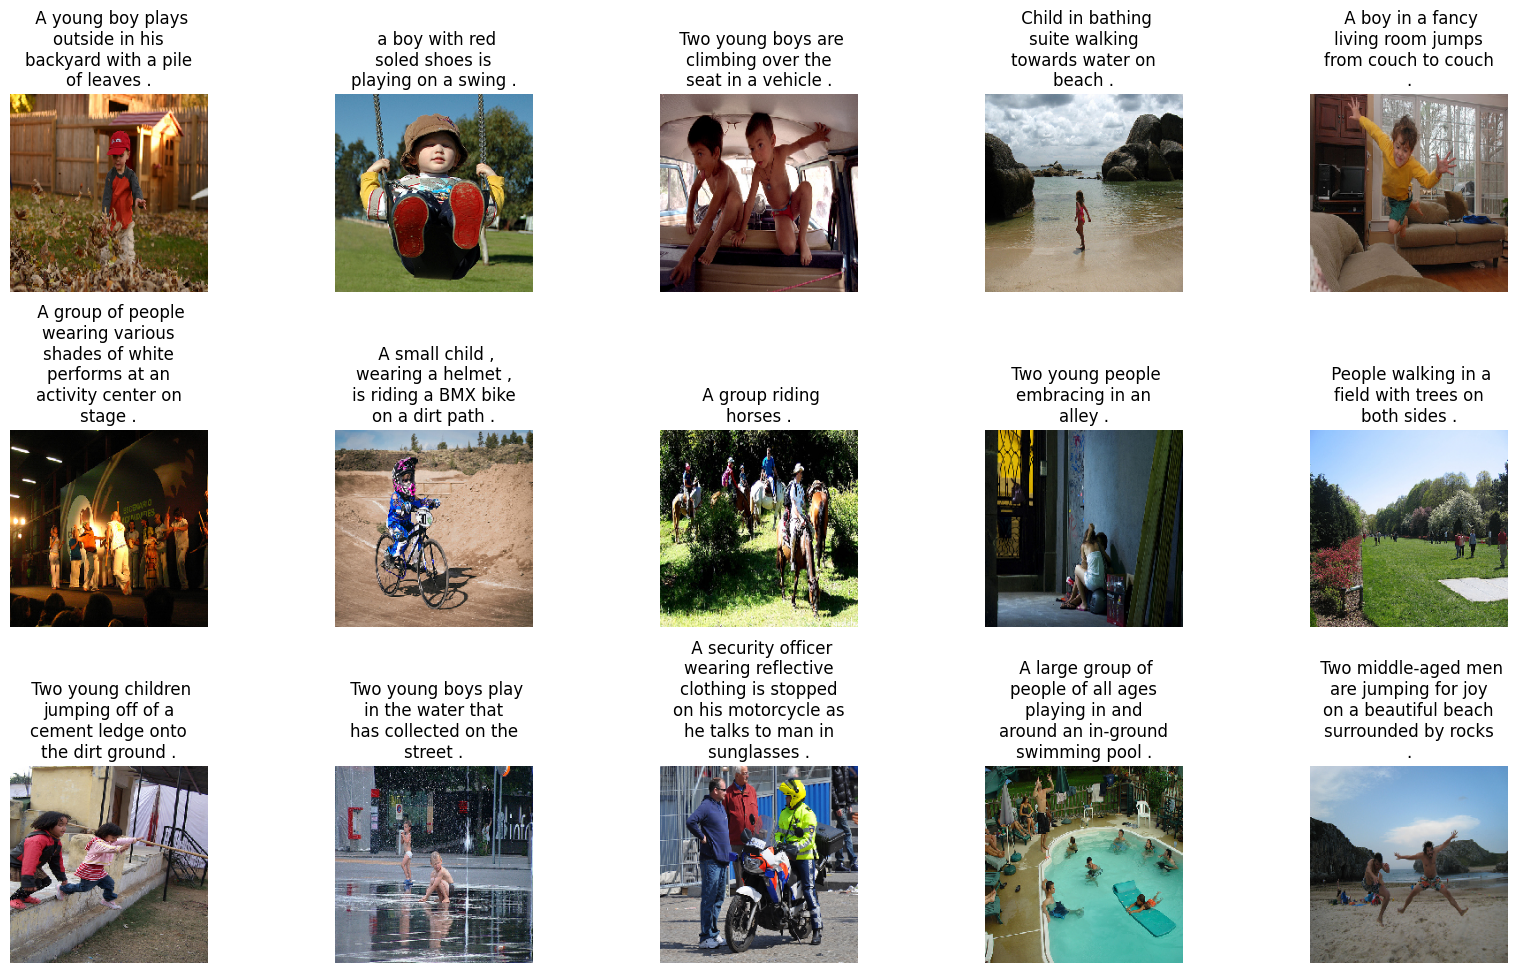

In [3]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"C:/Users/muham/Documents/COOLYEAH/Semester 7/Bangkit/Capstone/EyesOnMe-ML/flickr30k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

In [4]:
def text_preprocessing(data):
    data['caption'] = data['caption'].astype(str)
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = "<start> " + data['caption'] + " <end>"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\muham\AppData\Local\Temp\ipykernel_14692\2094180366.py:5: SyntaxWarning: invalid escape sequence '\s'
  data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))


In [5]:
# Initialize TextVectorization layer
vectorizer = tf.keras.layers.TextVectorization(
    standardize=None,
    max_tokens=None,
    output_mode='int',
    output_sequence_length=None
)

# Adapt the TextVectorization layer on the captions
vectorizer.adapt(captions)

# Extract vocabulary and set parameters
vocabulary = vectorizer.get_vocabulary()
VOCAB_SIZE = len(vocabulary) + 1  # +1 for any special token, if needed
MAX_LENGTH = max(len(caption.split()) for caption in captions)  # Same as before

# Convert captions to sequencesvo
sequences = vectorizer(captions).numpy()

# Pad sequences to have the same length
padded_sequences = tf.keras.utils.pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

# Split dataset into train, validation, and test sets (unchanged)
images = data['image'].unique().tolist()
nimages = len(images)

train_split = round(0.7 * nimages)
val_split = round(0.85 * nimages)

train_images = images[:train_split]
val_images = images[train_split:val_split]
test_images = images[val_split:]

train_data = data[data['image'].isin(train_images)].reset_index(drop=True)
val_data = data[data['image'].isin(val_images)].reset_index(drop=True)
test_data = data[data['image'].isin(test_images)].reset_index(drop=True)

In [6]:
# Extract train, val, test images and captions
train_imgs = train_data['image'].tolist()
val_imgs = val_data['image'].tolist()
test_imgs = test_data['image'].tolist()

train_captions = train_data['caption'].tolist()
val_captions = val_data['caption'].tolist()
test_captions = test_data['caption'].tolist()

# Define helper functions
def get_full_path(imgs):
    return [f"{image_path}/{img}" for img in imgs]

# Apply helper functions
train_imgs = get_full_path(train_imgs)
val_imgs = get_full_path(val_imgs)
test_imgs = get_full_path(test_imgs)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_captions))
val_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_captions))
test_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_captions))

vectorizer = tf.keras.layers.TextVectorization( 
    standardize=None,
    max_tokens=VOCAB_SIZE,
    ragged=True
)
# caption_only = train_dataset.map(lambda img, caption: caption)
vectorizer.adapt(train_captions)
vocabulary = vectorizer.get_vocabulary()

print(len(vocabulary), vocabulary[:5], vectorizer(train_captions[0]), train_captions[0], end='\n\n')

ragged = vectorizer(train_captions)
padded = tf.keras.utils.pad_sequences(sequences=ragged.to_list(), padding='post', maxlen=MAX_LENGTH)

ragged[0], padded[0], train_captions[0]

16809 ['', '[UNK]', np.str_('<start>'), np.str_('<end>'), np.str_('in')] tf.Tensor(
[   2   13   21  343   11 1931  111  188   17   63  160   25  327   73
    4    5  426    3], shape=(18,), dtype=int64) <start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>



(<tf.Tensor: shape=(18,), dtype=int64, numpy=
 array([   2,   13,   21,  343,   11, 1931,  111,  188,   17,   63,  160,
          25,  327,   73,    4,    5,  426,    3])>,
 array([   2,   13,   21,  343,   11, 1931,  111,  188,   17,   63,  160,
          25,  327,   73,    4,    5,  426,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 '<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>')

In [10]:
# model = ResNet101V2()
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 224
# imgpaths = np.unique(train_imgs + val_imgs + test_imgs)
# features3 = {}
# for imgpath in tqdm(imgpaths):
#     img = load_img(imgpath,target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature3 = fe.predict(img, verbose=0)
#     features3[imgpath] = feature3

# # Simpan fitur ke file
# with open('features3.pkl', 'wb') as f:
#     pickle.dump(features3, f)

# # Membaca fitur dari file
# # with open('features.pkl', 'rb') as f:
# #     features = pickle.load(f)

# # Akses fitur
# # print(loaded_features['path_to_image.jpg'])

100%|██████████████████████████████████████████████████████████████████████████| 31783/31783 [3:29:38<00:00,  2.53it/s]


In [8]:
# model = EfficientNetB5()
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 456
# imgpaths = np.unique(train_imgs + val_imgs + test_imgs)
# features2 = {}
# for imgpath in tqdm(imgpaths):
#     img = load_img(imgpath,target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature2 = fe.predict(img, verbose=0)
#     features2[imgpath] = feature2

# # Simpan fitur ke file
# with open('features2.pkl', 'wb') as f:
#     pickle.dump(features2, f)

# # Membaca fitur dari file
# # with open('features.pkl', 'rb') as f:
# #     features = pickle.load(f)

# # Akses fitur
# # print(loaded_features['path_to_image.jpg'])

100%|██████████████████████████████████████████████████████████████████████████| 31783/31783 [6:46:23<00:00,  1.30it/s]


In [9]:
# model = DenseNet201()
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 224
# imgpaths = np.unique(train_imgs + val_imgs + test_imgs)
# features = {}
# for imgpath in tqdm(imgpaths):
#     img = load_img(imgpath,target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature = fe.predict(img, verbose=0)
#     features[imgpath] = feature

100%|██████████| 31783/31783 [4:16:20<00:00,  2.07it/s]  


In [8]:
# Simpan fitur ke file
# with open('features.pkl', 'wb') as f:
#     pickle.dump(features, f)

# Membaca fitur dari file
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
features = {os.path.basename(path): value for path, value in features.items()}
# Akses fitur
# print(loaded_features['path_to_image.jpg'])

In [9]:
input1 = Input(shape=(1, 1920))
input2 = Input(shape=(MAX_LENGTH,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(VOCAB_SIZE, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
output = Dense(VOCAB_SIZE, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
caption_model.summary()

C:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1, 1920)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1, 256)            │         491,776 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 74)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 256)            │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 74, 256)           │       5,190,912 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 75, 256)           │               0 │ reshape[0][0],             │
│                               │                           │                 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         525,312 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1, 256)            │               0 │ dropout[0][0], dense[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1, 128)            │          32,896 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 1, 128)            │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 128)               │               0 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 20277)             │       2,615,733 │ flatten[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,856,629 (33.79 MB)

 Trainable params: 8,856,629 (33.79 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, features, vectorizer, vocab_size, max_length, batch_size, shuffle=True):
        """
        df: DataFrame yang berisi data gambar dan caption.
        X_col: Nama kolom untuk gambar (path atau nama file).
        y_col: Nama kolom untuk caption.
        features: Dictionary berisi fitur gambar.
        vectorizer: TextVectorization layer untuk memproses caption.
        max_length: Panjang maksimum caption setelah padding.
        batch_size: Ukuran batch.
        shuffle: Apakah data perlu diacak pada akhir epoch.
        """
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.features = features
        self.vectorizer = vectorizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.indices = np.arange(self.n)

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return self.n // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        """
        Mengembalikan batch data pada indeks tertentu.
        """
        start = index * self.batch_size
        end = start + self.batch_size
        batch_indices = self.indices[start:end]
        batch_df = self.df.iloc[batch_indices]

        return self.__get_data(batch_df)

    def __get_data(self, batch_df):
        X1, X2, y = [], [], []
    
        images = batch_df[self.X_col].tolist()
    
        for image in images:
            # Ambil fitur gambar
            feature = self.features[image][0]  # Pastikan ini hanya sekali diambil
    
            # Ambil semua caption yang terkait dengan gambar ini
            captions = batch_df.loc[batch_df[self.X_col] == image, self.y_col].tolist()
    
            for caption in captions:
                # Proses caption dengan vectorizer
                seq = self.vectorizer(caption).numpy()
    
                # Iterasi untuk membuat pasangan input-output
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = tf.keras.utils.pad_sequences([in_seq], maxlen=self.max_length, padding="pre")[0]
                    # One-hot encode output sequence
                    out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=self.vocab_size)[0]
    
                    # Tambahkan ke batch
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
    
        # Konversi ke array numpy
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        X1 = np.expand_dims(X1, axis=1)
    
        return (X1, X2), y

In [11]:
train_generator = CustomDataGenerator(
    df=train_data,
    X_col='image',
    y_col='caption',
    features=features,
    vectorizer=vectorizer,
    vocab_size=VOCAB_SIZE,
    max_length=MAX_LENGTH,
    batch_size=64,
    shuffle=True
)

validation_generator = CustomDataGenerator(
    df=test_data,
    X_col='image',
    y_col='caption',
    features=features,
    vectorizer=vectorizer,
    vocab_size=VOCAB_SIZE,
    max_length=MAX_LENGTH,
    batch_size=64,
    shuffle=False
)

In [12]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

C:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


C:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1326/1738 ━━━━━━━━━━━━━━━━━━━━ 24:38 4s/step - accuracy: 0.1553 - loss: 5.5956

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
def predict_caption(model, image, vectorizer, max_length, features):
    feature = features[image]
    feature = tf.convert_to_tensor(feature)
    feature = tf.expand_dims(feature, axis=0)
    in_text = "<start>"
    for i in range(max_length):
        sequence = vectorizer([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        
        y_pred = model.predict((feature, sequence), verbose=0)
        y_pred = np.argmax(y_pred)
        
        word = vectorizer.get_vocabulary()[y_pred]
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == '<end>':            
            break
            
    return in_text

In [ ]:
path = train_imgs[150]
img = load_img(path, color_mode='rgb',target_size=(244,244))
img = img_to_array(img)
img /= 255
plt.imshow(img)
predict_caption(caption_model, path, vectorizer, MAX_LENGTH, features)

In [ ]:
caption_model.save("model_after_training.keras")